# ARIMA Model for Time Series Forecasting in Python

ARIMA is an acronum that stands for AutoRegressive Integrated Moving Average. It is a class of model taht captures a suite of different standard temporal structures in time series data.

After completing this tutorial, you will know:
- About the ARIMA model, the parameters used, and assumptions made by the model.
- How to fit an ARIMA model to data and use it to make forecasts.
- How to configure the ARIMA model on your time series problem.

# AutoRegressive Integrated Moving Average Model

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
- `AR`**Autoregression** : A model that uses the dependent relationship between an observation and some number of lagged observations.
- `I` **Integrated** : The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- `MA` **Moving Average** : A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as parameters. The parameters of the ARIMA model are defined as follows:
- `p` : The number of lag observations included in the model, also called the **lag order**.
- `d` : The number of times that the raw observations are differenced, also call the **degree of differencing**,
- `q` : The size of the moving average window, also called the **order of moving average**.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary. In other words, differencing removes trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates that it should not be used for the model. This way, the ARIMA model can be configured to perform the function of an ARMA model or even simpler AR, I, or MA models.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but it helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(palette='viridis')

# Shampoo Sales Dataset

This dataset describes the monthly number of sales of shampoo over a 3-year period. The units are a sales count and there are 36 observations.

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


/var/folders/xm/yv4_9lnx4vxb435678j65d140000gn/T/ipykernel_14081/2322475242.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv(
/var/folders/xm/yv4_9lnx4vxb435678j65d140000gn/T/ipykernel_14081/2322475242.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime('190' + x, '%Y-%m')


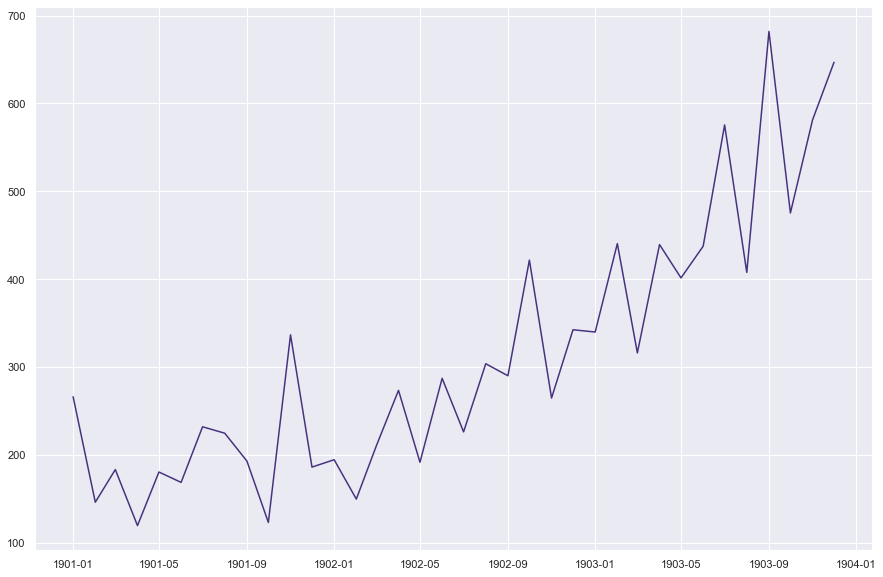

In [8]:
def parser(x):
    return pd.datetime.strptime('190' + x, '%Y-%m')

series = pd.read_csv(
    './res/data/shampoo.csv', 
    header=0, 
    parse_dates=[0], 
    index_col=0,
    squeeze=True,
    date_parser=parser)

print(series.head())
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(series)
plt.show()


This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

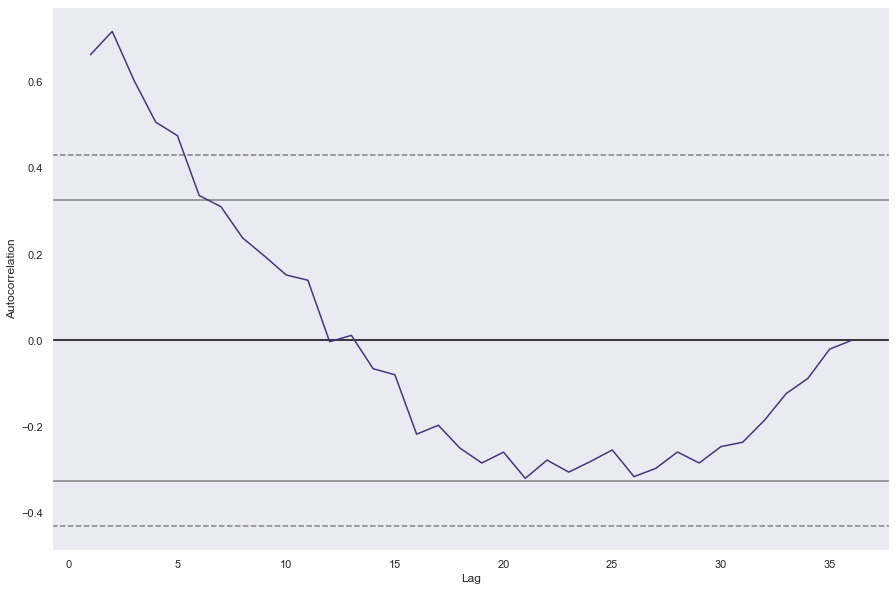

In [10]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(15,10))
autocorrelation_plot(series, ax)
plt.show()

Refer to the autocorrelation plot for a large number of lags in the time series. We can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

## ARIMA with Python

We will fit an ARIMA model to the entire Shampoo sales dataset and review the residual errors. First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Wed, 08 Jun 2022   AIC                            408.969
Time:                        02:46:53   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

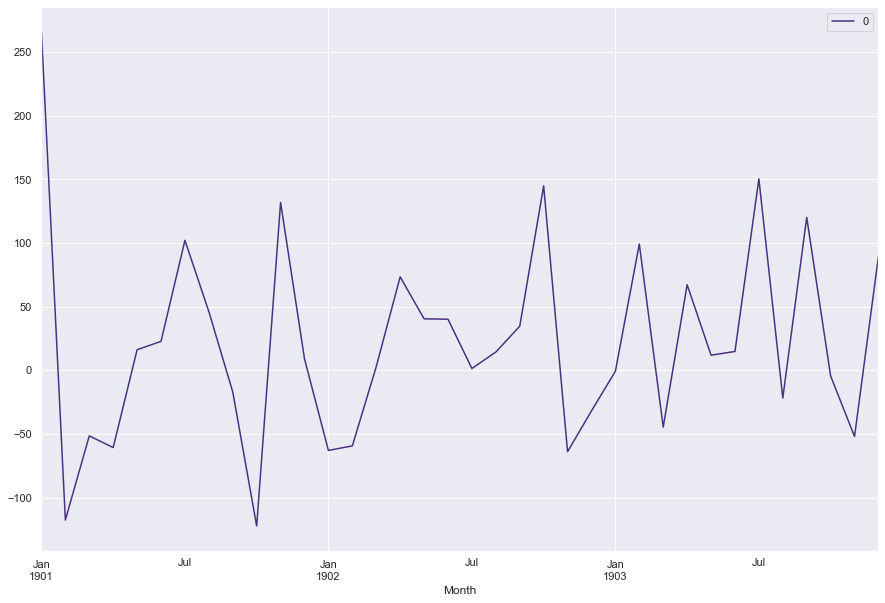

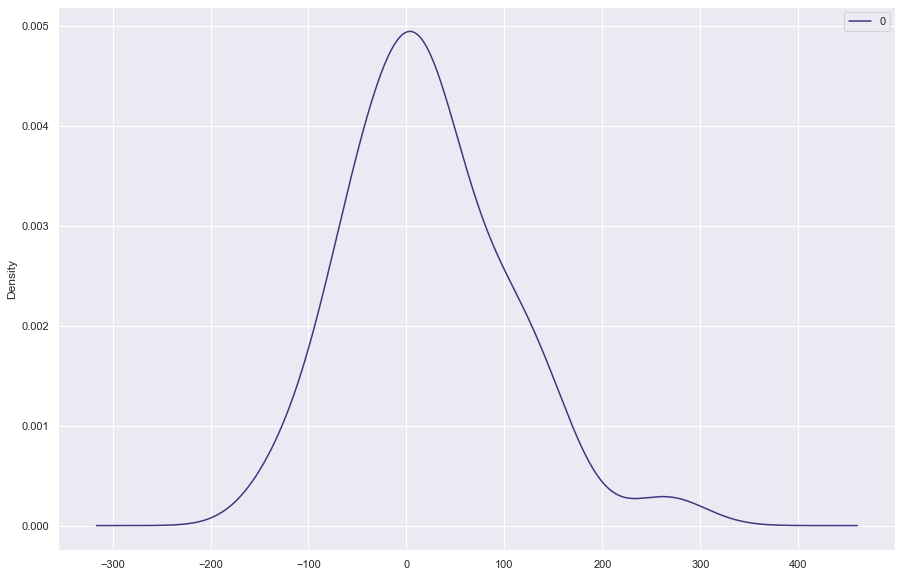

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147218
75%     68.848286
max    266.000000


In [25]:
from statsmodels.tsa.arima.model import ARIMA

# series.index = series.index.to_period('M')

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)

fg,ax1 = plt.subplots(figsize=(15,10))
residuals.plot(ax=ax1)
plt.show()

# density plot of residuals
fg, ax2 = plt.subplots(figsize=(15,10))
residuals.plot(ax=ax2, kind='kde') # generate a kernel density estimate plot using Gaussian kernels
plt.show()

# summary stats of residuals
print(residuals.describe())

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model. Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centered on zero.

In statistics, `kernel density estimation` (KDE) is a non-parametric way to estimate the `probability density function` (PDF) of a random variable. This function uses Gaussian kernels and icnludes automatic bandwidth determination.

The distribution of the residual errors is displayed. The results show that there is a bias in the prediction (a non-zero mean in the residuals).

## Rolling Forecast ARIMA Model

The ARIMA model can be used to forecast future time steps.

We can use the `predict()` function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as `start=101, end=101`. This would return an array with one element containing the prediction.

We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (`d > 0` when configuring the model). This can be specified by setting the `typ` argument to the value `levels` (i.e., `typ=levels`).

Alternately, we can avoid all of these specifications by using the `forecast()` function, which performs a one-step forecast using the model. We can split the training dataset into train and test sets, use the train set to fit the model, and generate a one-step forecast using the model.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually record all observations in a list called `history` that is seeded with the training data and to which new observations are appended every iteration.

predicted = 293.3296741565983, expected = 339.7
predicted = 368.6689557772336, expected = 440.4
predicted = 335.0447406915547, expected = 315.9
predicted = 363.2202215542528, expected = 439.3
predicted = 357.6453236672947, expected = 401.3
predicted = 443.047835235048, expected = 437.4
predicted = 378.3656735879119, expected = 575.5
predicted = 459.41502033946733, expected = 407.6
predicted = 526.8908757428344, expected = 682.0
predicted = 457.2312746585303, expected = 475.3
predicted = 672.9149431943906, expected = 581.3
predicted = 531.5414492920253, expected = 646.9
RMSE: 92.65562750544859


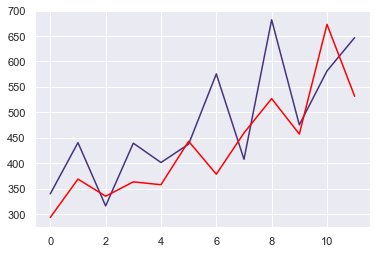

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt

x = series.values

# important to not shuffle here; order is important for time series data
xtrain, xtest = train_test_split(x, test_size=0.33, shuffle=False)
history = [x for x in xtrain]
predictions = list()

# walk-forward validation
for t in range(len(xtest)):
    # fit data
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    
    # predict forecast
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    obs = xtest[t]
    history.append(obs)
    
    print(f'predicted = {yhat}, expected = {obs}')
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(xtest, predictions))
print(f'RMSE: {rmse}')

# plot forecasts against actual outcomes
plt.plot(xtest)
plt.plot(predictions, color='red')
plt.show()

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale. This model could use further tuning of the `p`, `d`, and maybe even the `q` parameters.

## Configuring the ARIMA model

The classical approach for fitting an ARIMA model is to follow the Box-Jenkins Methodology.

This is a process that uses time series analysis and diagnostics to discover good parameters for the ARIMA model.

In summary, the steps of this process are as follows:

1. `Model Identification` : Use plots and summary statistics to identify trends, seasonality, and autoregression elements to get an idea of the amount of differencing and the size of the lag that will be required.
2. `Parameter Estimation` : Use a fitting procedure to find the coefficients of the regression model.
3. `Model Checking` : Use plots and statistical tests of the residual errors to determine the amount and type of temporal structure not captured by the model.

The process is repeated until either a desirable level of fit is achieved on the in-sample or out-of-sample observations (e.g. training or test datasets).

Given that the model can be fit efficiently on modest-sized time series datasets, grid searching parameters of the model can be a valuable approach.